In [11]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys

# Add the project directory to sys.path
project_dir = Path.cwd().parent  # Adjust as needed to point to your project root
sys.path.append(str(project_dir))

print("project_dir: ", project_dir)
from utils.pipeline_fixed import Pipeline, EvaluationEnum

dataloader = Pipeline(evaluation=EvaluationEnum.BALANCE)

file_tag = "security"
eval_metric = "accuracy"

trnX, tstX, trnY, tstY, target, labels = dataloader.get_security_classification_train_test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
project_dir:  /Users/hugojarudd/Desktop/kdd-process/src


In [12]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)
from pandas import Series, DataFrame
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart
import pandas as pd
from sklearn.model_selection import train_test_split


In [13]:

train = pd.concat([trnX, trnY], axis=1)
test = pd.concat([tstX, tstY], axis=1)

# Correlation analysis

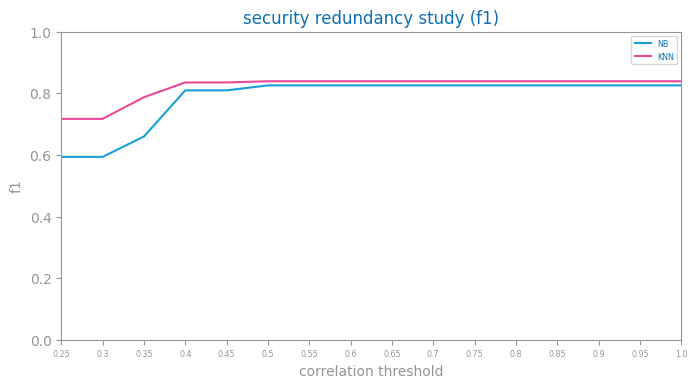

In [14]:
def study_redundancy_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "CLASS__security",
    min_threshold: float = 0.90,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(min_threshold + i * lag, 3)
        for i in range(ceil((1 - min_threshold) / lag) + 1)
    ]

    df: DataFrame = train.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    results: dict[str, list] = {"NB": [], "KNN": []}
    for thresh in options:
        vars2drop: list = []
        for v1 in variables:
            vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= thresh]
            vars_corr.drop(v1, inplace=True)
            if len(vars_corr) > 1:
                lst_corr = list(vars_corr.index)
                for v2 in lst_corr:
                    if v2 not in vars2drop:
                        vars2drop.append(v2)

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} redundancy study ({metric})",
        xlabel="correlation threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_redundancy_{metric}_study.png")
    return results


eval_metric = "f1"

figure(figsize=(2 * HEIGHT, HEIGHT))
study_redundancy_for_feature_selection(
    train,
    test,
    target=target,
    min_threshold=0.25,
    lag=0.05,
    metric=eval_metric,
    file_tag=file_tag,
)
show()


 Since the lines are constant after 0.4, variables with higher correlation than this will be dropped 

In [15]:
def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "CLASS__security"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop


print("Original variables", train.columns.values)
vars2drop: list[str] = select_redundant_variables(
    train, target=target, min_threshold=0.4
)
print("Variables to drop", sorted(vars2drop))

Original variables ['PD_CD' 'KY_CD' 'OFNS_DESC' 'LAW_CODE' 'LAW_CAT_CD' 'ARREST_BORO'
 'ARREST_PRECINCT' 'AGE_GROUP' 'PERP_SEX' 'PERP_RACE' 'Latitude'
 'Longitude' 'YEAR' 'MONTH' 'DAY_OF_WEEK' 'IS_WEEKEND' 'DAY_OF_YEAR_sin'
 'DAY_OF_YEAR_cos' 'CLASS__security']
Variables to drop ['ARREST_PRECINCT', 'Longitude']


In [16]:
train = train.drop(columns=vars2drop)
test = test.drop(columns=vars2drop)

# Variability analysis

In [17]:
from pandas import DataFrame, Index, read_csv
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "CLASS"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)



print("Original variables", train.columns.to_list())
vars2drop: list[str] = select_low_variance_variables(train, 1.2, target=target)
print("Variables to drop", vars2drop)

Original variables ['PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'IS_WEEKEND', 'DAY_OF_YEAR_sin', 'DAY_OF_YEAR_cos', 'CLASS__security']
Variables to drop ['PD_CD', 'KY_CD', 'OFNS_DESC', 'LAW_CAT_CD', 'ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'Latitude', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'IS_WEEKEND', 'DAY_OF_YEAR_sin', 'DAY_OF_YEAR_cos']


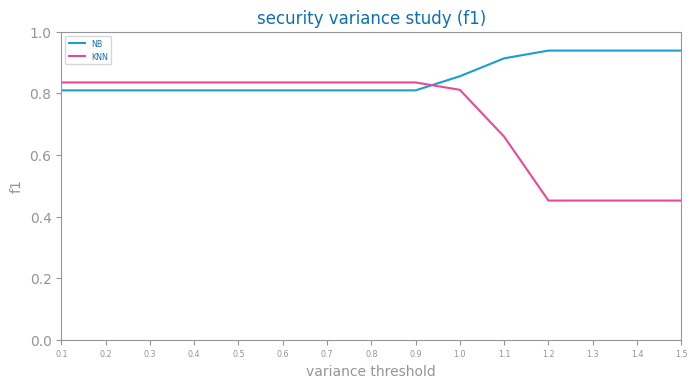

In [18]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "CLASS",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    #file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in options:
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "f1"




figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train,
    test,
    target=target,
    max_threshold=1.5,
    lag=0.1,
    metric=eval_metric,
    #file_tag=file_tag,
)
show()


Since the NB model sees a sharp increase in performance when variables with variance under 1.2 are dropped, these will be dropped.